# Import modules

In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
from math import exp

# Initial parameters

In [2]:
# Population size
n = 1 

# Default Time beginning (second)
t = 0

# Default trial duration (second)
duration = 1.00  # 

# Default Time resolution (second)
dt = 0.0001  #

In [3]:
# Weights 
# connextions pre->post ; notation: PostPre
connections = ["GPeMsnD2", "SNrGPe", "ThaSNr", "MsnD2Tha", "MsnD1Tha"]
structures = ["MsnD1", "MsnD2", "GPe", "SNr", "Tha"]

# Thresholds
h = {
    "MsnD1": -51.90,   # Mahon et al., 2006. RAT
    "MsnD2": -51.90,   # Mahon et al., 2006. RAT
    "GPe": -55.10,   # Abdi, Mallet et al., 2015. RAT (In Vitro)
    "SNr": -39.0,
    "Tha": -47.00    # Leblois et al. Paper 2006
}

# inputs
I = dict()
for stc in structures:
    I[stc] = 0


G = {
    "GPeMsnD2": 1.00,
    "SNrGPe": 1.00,
    "ThaSNr": 1.00,
    "MsnD2Tha": 1.00,
    "MsnD1Tha": 1.00
}

# tau:
tau = {
    "GPeMsnD2": 0.005,
    "SNrGPe": 0.020,
    "ThaSNr": 0.005,
    "MsnD2Tha": 0.005,
    "MsnD1Tha": 0.005
}

# Delays:
D = {
    "GPeMsnD2": 0.010,
    "SNrGPe": 0.006,
    "ThaSNr": 0.005,
    "MsnD2Tha": 0.005,
    "MsnD1Tha": 0.005
}

In [4]:
# Activities at time t, with dt step and Connectivity J:
m, dm, J = dict(), dict(), dict()

for con in connections:

    m[con] = 0
    dm[con] = 0
    J[con] = 1
    
input_mapping = {
    "MsnD1": "MsnD1Tha",
    "MsnD2": "MsnD2Tha",
    "GPe": "GPeMsnD2",
    "SNr": "SNrGPe",
    "Tha": "ThaSNr"
}

activities_mapping = {
    "GPeMsnD2": "MsnD2",
    "SNrGPe": "GPe",
    "ThaSNr": "SNr",
    "MsnD2Tha": "Tha",
    "MsnD1Tha": "Tha"
}


In [5]:
# Noise level (%)  = sigma from paper
N = {
    "MsnD1": 0.05,
    "MsnD2": 0.05,
    "GPe": 0.05,
    "SNr": 0.05,
    "Tha": 0.05
}

# Initialization of the random generator (reproductibility !)
np.random.seed(1)

# Noise Function

In [6]:
# White Gaussian Noise
def WGnoise(size=1):
    n = np.random.normal(0, 1, size=size)
    return n


def noise(Z, level):  # Z = size of the population
    Z = (np.random.uniform(-level / 2, level / 2, Z)) * Z
    return Z

# Corrected Input function

In [7]:
# Function returning the corrected Input
def Ic(Input=0, threshold=0):
    if Input - threshold <= 0:
        return 0
    else:
        return (Input - threshold)

# Activity at time t-Delta (delay) function

In [8]:
# function to get the index "-delay/dt" in the list representing m(t-Delta)
def mdelta(synapse_value, delay, t, dt):
    if t < delay:  # if the delay is the time is too small, we take m(t-delta)=0
        return 0
    else:  # if the time is above or equal to the delay, we can find the m(t-delta)
        return synapse_value[int(-delay / dt)]

# - Simulation Core -

In [9]:
n_period = int(duration // dt) + 1
time_value = np.arange(0, duration, dt)

mDelta, value = dict(), dict()

for con in connections:
    value[con] = np.zeros(n_period)

for t in range(1, n_period):

    for con in connections:
        
        value[con][t] = m[con]  # command to add all activities of each population in a list respectively ; 
        # after each iteration

        mDelta[con] = mdelta(value[con][:t + 1], D[con], time_value[t], dt)

        m[con] += dm[con]  # we add the activity (dm) to the global activity (m),
            # after a step dt ; for all population
            # stored in the list ("PopulationNames"_value)

    # noise_level = WGnoise(len(structures) + 2)
    for stc in structures:
        if stc == "GPe" or "MsnD1" or "MsnD2":
            con = input_mapping[stc]
            I[stc] = - G[con] * J[con] * mDelta[con] + WGnoise()
        else:
            con = input_mapping[stc]
            I[stc] = G[con] * J[con] * mDelta[con] + WGnoise()

    for con in connections:
        # Update of activities
        stc = activities_mapping[con]
        dm[con] = dt * (-m[con] + Ic(I[stc], h[stc])) / tau[con] + float(noise(1, N[stc]))

# Plotting results

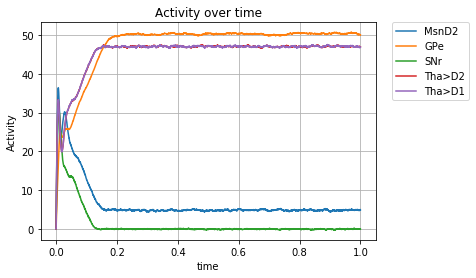

In [10]:
plt.plot(time_value, value["GPeMsnD2"], label='MsnD2')
plt.plot(time_value, value["SNrGPe"], label='GPe')
plt.plot(time_value, value["ThaSNr"], label='SNr')
plt.plot(time_value, value["MsnD2Tha"], label='Tha>D2')
plt.plot(time_value, value["MsnD1Tha"], label='Tha>D1')


plt.title('Activity over time')
plt.ylabel('Activity')
plt.xlabel('time')
plt.grid()

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()